# KOH Posterior Analysis using Mici

In [2]:
from models import toymodel as KOHmodel
from data.dataloader import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from jax import jit, grad

import numpy as np
import matplotlib.pyplot as plt

import mici
import arviz

from truefuncs import zeta
eta = zeta

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

# The data

In [3]:
dataloader = DataLoader('data/toy/field.csv', 'data/toy/sim.csv')
data = dataloader.get_data()
model = KOHmodel.Model(*data)

tmax = dataloader.t_max
tmin = dataloader.t_min

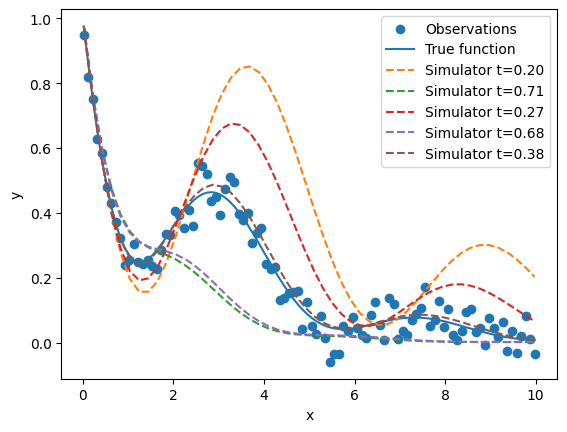

In [4]:
fig, ax = plt.subplots(1, 1)
ax.scatter(dataloader.xf, dataloader.yf, label='Observations')
ax.plot(dataloader.xf, zeta(dataloader.xf, 0.4), label='True function')
rng = np.random.default_rng()
ts = rng.permutation(np.unique(dataloader.tc))[:5]
for t in ts:
    rows = dataloader.tc==t
    ax.plot(dataloader.xc[rows], dataloader.yc[rows], '--', label=f'Simulator t={t:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

# MCMC Setup

In [5]:
theta_0 = 0.5

ell_eta_0_0 = 1 # np.sqrt(np.var(dataloader.xf))/3
ell_eta_1_0 = 0.3 # np.sqrt(np.var(dataloader.tc))/3
ell_delta_0_0 = 1 # np.sqrt(np.var(dataloader.xf))/5

lambda_eta_0 = 1
lambda_delta_0 = 30
lambda_epsilon_0 = 400
lambda_epsilon_eta_0 = 10000

init_states = np.array([[
    map01toR(theta_0), 
    map0inftoR(ell_eta_0_0),
    map0inftoR(ell_eta_1_0),
    map0inftoR(ell_delta_0_0),
    map0inftoR(lambda_eta_0),
    map0inftoR(lambda_delta_0),
    map0inftoR(lambda_epsilon_0),
    map0inftoR(lambda_epsilon_eta_0),
]])

Build the transform function to translate Mici's unbounded parameters into bounded GPJAX parameters.
This is passed to KOHGPJax.

In [6]:
param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0]),
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]), 
        mapRto0inf(x[3]),
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6]), 
        mapRto0inf(x[7]),
    ]
]

Build the function for evaluating the negative log posterior density.

This function is jitted and grad jitted using JAX. Finally the JAX functions are wrapped into a numpy function for clean interactions with Mici.

In [7]:
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)
grad_neg_log_posterior_density = jit(grad(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
))

def neg_log_pos_dens(x):
    return np.asarray(jitted_neg_log_posterior_density(x))

def grad_neg_log_pos_dens(x):
    return np.asarray(grad_neg_log_posterior_density(x))

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=neg_log_pos_dens,
    grad_neg_log_dens=grad_neg_log_pos_dens,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

# Running MCMC algorithm

In [8]:
seed = 1234
n_chain = 1 # only 1 works on MacOS
n_warm_up_iter = 200
n_main_iter = 500
rng = np.random.default_rng(seed)

##### Mici sampler and adapters #####
# sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=3)
sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'm_theta': state.pos[0], 
        'm_ell_eta_0': state.pos[1], 
        'm_ell_eta_1': state.pos[2],
        'm_ell_delta_0': state.pos[3],
        'm_lambda_eta': state.pos[4],
        'm_lambda_delta': state.pos[5],
        'm_lambda_epsilon': state.pos[6],
        'm_lambda_epsilon_eta': state.pos[7],
        'hamiltonian': system.h(state)
    }

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    init_states, 
    adapters=adapters, 
    n_process=n_chain, # only 1 works on MacOS
    trace_funcs=[trace_func]
)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Sampling stage: Initial fast adaptive [02:14] > Slow adaptive (1/2) [01:10] > Slow adaptive (2/2) [00:21] > Final fast adaptive [00:16] > Main non-adaptive [02:12]

Chain 1/1: 100%|██████████|500/500 [02:12<00:00, 3.77it/s, accept_stat=0.893]

# Analyse MCMC output

In [9]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hamiltonian,-2247.112,3.008,-2252.487,-2241.788,0.242,0.171,167.0,183.0,NaN
m_ell_delta_0,1.212,0.315,0.601,1.771,0.016,0.011,406.0,314.0,NaN
m_ell_eta_0,0.781,0.031,0.721,0.836,0.001,0.001,709.0,369.0,NaN
m_ell_eta_1,-1.339,0.042,-1.411,-1.258,0.001,0.001,843.0,332.0,NaN
m_lambda_delta,3.302,0.654,2.057,4.412,0.035,0.025,378.0,358.0,NaN
m_lambda_epsilon,6.262,0.131,6.024,6.489,0.004,0.003,824.0,394.0,NaN
m_lambda_epsilon_eta,12.219,0.067,12.097,12.359,0.003,0.002,722.0,325.0,NaN
m_lambda_eta,-1.266,0.319,-1.857,-0.707,0.012,0.009,718.0,430.0,NaN
m_theta,0.494,0.071,0.369,0.644,0.004,0.003,370.0,203.0,NaN


In [10]:
for var, trace in traces.items():
    print(var, ": ", np.mean(trace[0]), '±', np.std(trace[0]))

m_theta :  0.49419928584026446 ± 0.07047343272944938
m_ell_eta_0 :  0.781204165830379 ± 0.03070329018497234
m_ell_eta_1 :  -1.3392615817339635 ± 0.042212994459852965
m_ell_delta_0 :  1.2119015064329277 ± 0.31425120668940704
m_lambda_eta :  -1.2658442821010059 ± 0.31825195571106346
m_lambda_delta :  3.3020081867484925 ± 0.6531346449970015
m_lambda_epsilon :  6.261669161240574 ± 0.1311810143534408
m_lambda_epsilon_eta :  12.219449407075759 ± 0.06738437600355922
hamiltonian :  -2247.112105974842 ± 3.005202861452315


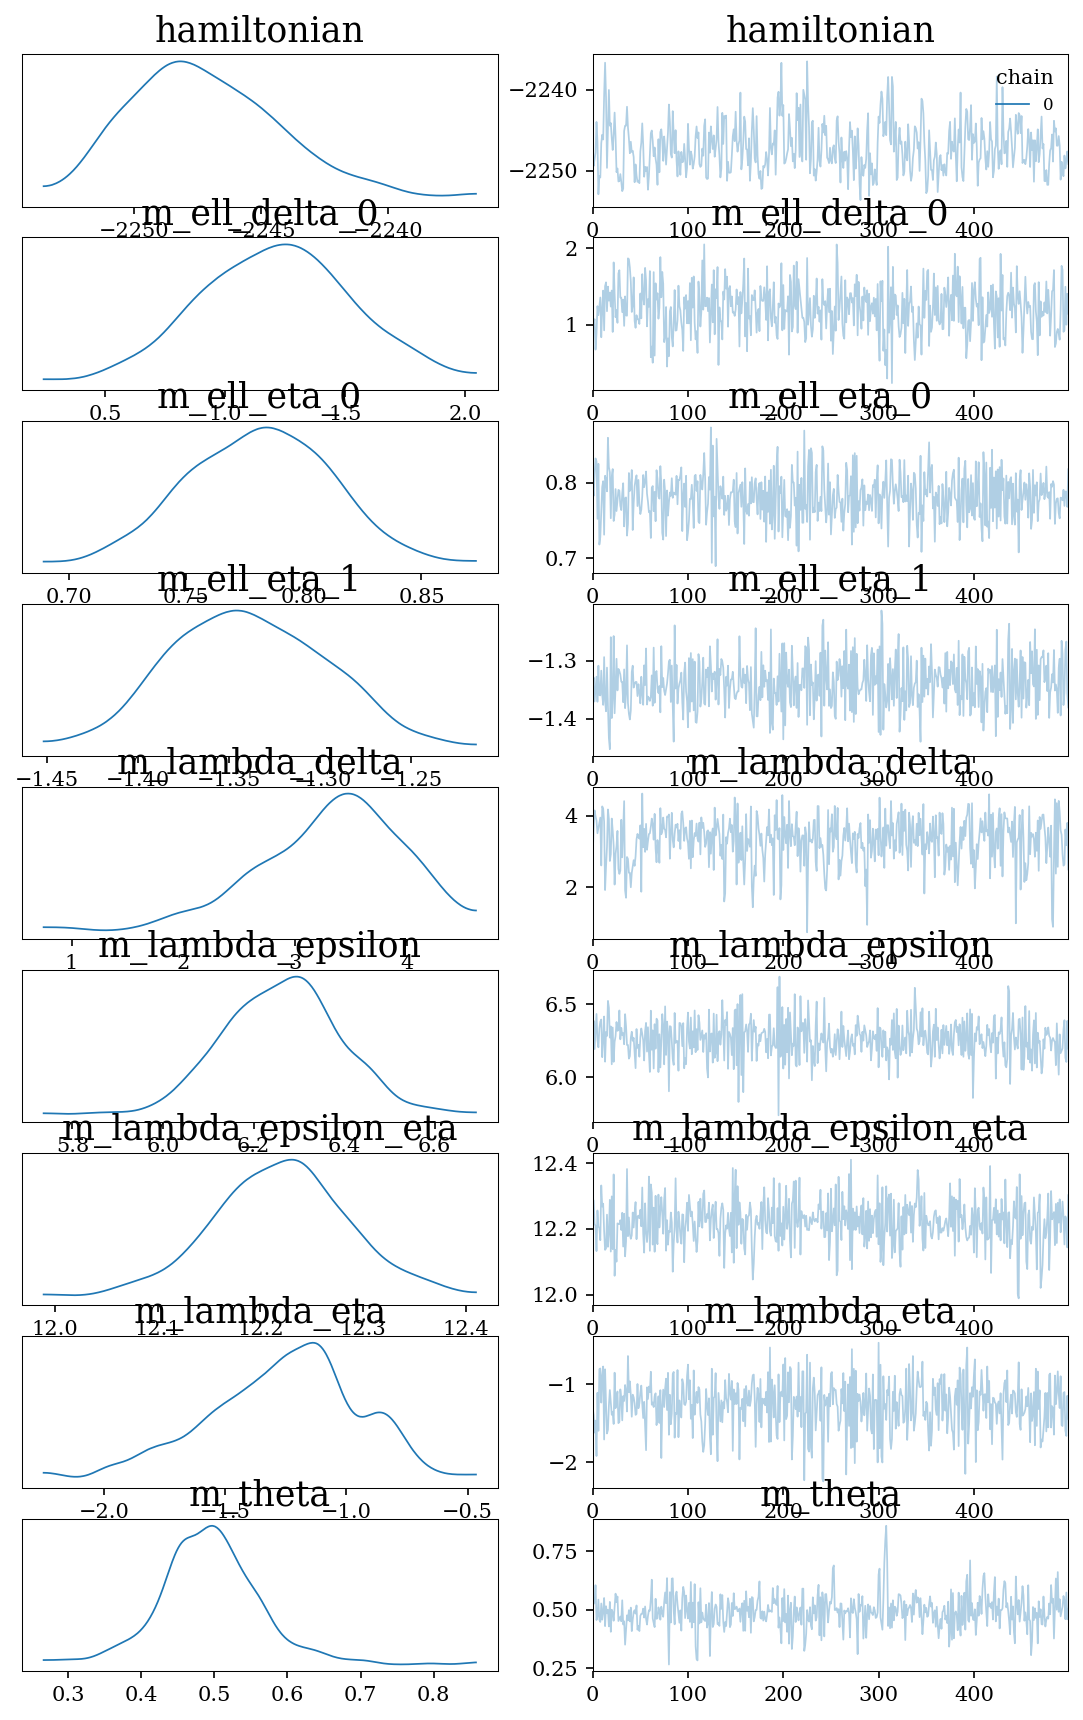

In [11]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )


# Transform the Chains

In [12]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'hamiltonian':
        continue
    var_name = var.split('m_')[1]
    if var_name == 'theta':
        traces_transformed[var_name] = mapRto01(trace[0])*(tmax-tmin) + tmin
    elif var_name.startswith('ell'):
        traces_transformed[var_name] = mapRto0inf(trace[0])
    elif var_name.startswith('lambda'):
        traces_transformed[var_name] = mapRto0inf(trace[0])

params_transformed = {}
for var, trace in traces_transformed.items():
    params_transformed[var] = np.mean(trace)
    print(var, ": ", np.mean(trace), '±', np.std(trace))

theta :  0.3819268056380654 ± 0.016012497660651683
ell_eta_0 :  2.185130207462621 ± 0.06708514647850533
ell_eta_1 :  0.26227305782623833 ± 0.011103010290465022
ell_delta_0 :  3.5293308501153264 ± 1.1266203595062791
lambda_eta :  0.2960589586275322 ± 0.09069895877110097
lambda_delta :  32.67163297653954 ± 18.757355597085386
lambda_epsilon :  528.6065341513391 ± 69.3954055443849
lambda_epsilon_eta :  203152.8234480568 ± 13653.685299494611


In [13]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ell_delta_0,3.529,1.128,1.611,5.653,0.053,0.038,406.0,314.0,NaN
ell_eta_0,2.185,0.067,2.050,2.298,0.003,0.002,709.0,369.0,NaN
ell_eta_1,0.262,0.011,0.244,0.284,0.000,0.000,843.0,332.0,NaN
lambda_delta,32.672,18.776,2.454,67.237,0.899,0.636,378.0,358.0,NaN
lambda_epsilon,528.607,69.465,413.434,657.913,2.445,1.824,824.0,394.0,NaN
lambda_epsilon_eta,203152.823,13667.359,175060.164,228268.063,513.298,363.106,722.0,325.0,NaN
lambda_eta,0.296,0.091,0.134,0.452,0.003,0.002,718.0,430.0,NaN
theta,0.382,0.016,0.348,0.411,0.001,0.001,370.0,203.0,NaN


In [14]:
from scipy.stats import gamma

priors = {
    # 'ell_delta_0': [4, 1],
    'ell_delta_0': [4, 2],
    'ell_eta_0': [4, 1.4],
    'ell_eta_1': [2, 3.5],
    # 'lambda_delta': [10, 0.3],
    'lambda_delta': [2, 0.1],
    'lambda_epsilon': [12, 0.025],
    'lambda_epsilon_eta': [10, 0.001],
    'lambda_eta': [2, 4],
}

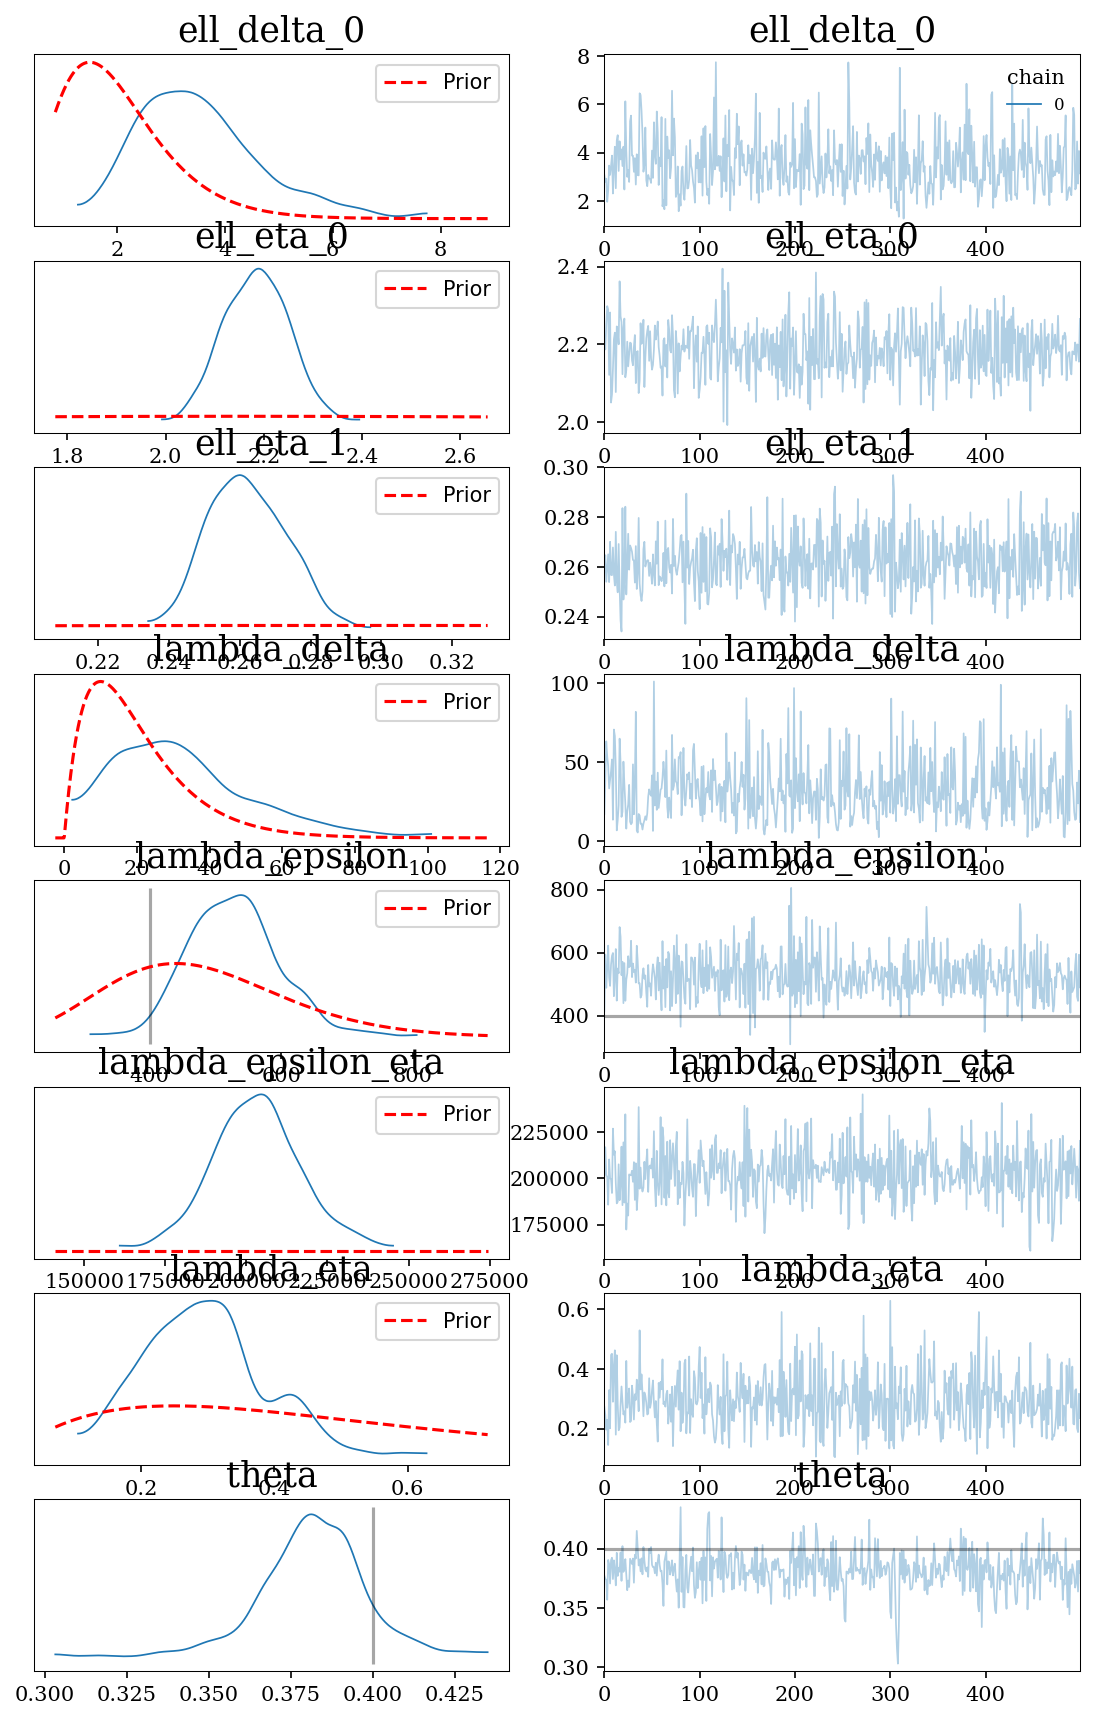

In [15]:
with plt.style.context(plot_style):
    axes = arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
        lines=(
            ('theta', {}, 0.4),
            ('lambda_epsilon', {}, 1/0.05**2)    
        )
    )
for i in range(axes.shape[0]):
    left, right = axes[i, 0].get_xlim()
    left, right = left*0.9, right*1.1
    x = np.linspace(left, right, 1000)
    title = axes[i, 0].get_title()
    if title in priors:
        alpha, beta = priors[title]
        pdf = gamma.pdf(x, a=alpha, scale=1/beta)
        axes[i, 0].plot(x, pdf, color='red', linestyle='--', label='Prior')
        axes[i, 0].legend()
plt.show()

# Analyse posterior fit

## Prediction data

In [16]:
xpred = np.linspace(0, 10, 1000)

# xp_normalised = (xpred-np.min(xpred))/(np.max(xpred)-np.min(xpred))
theta_transformed = mapRto01(np.mean(traces['m_theta'])) # transform theta back to [0, 1]

# x_test = np.vstack((xp_normalised, theta_transformed*np.ones_like(xp_normalised))).T
# dataset = model.dataset(theta_transformed)
x_test = np.vstack((xpred, theta_transformed*np.ones_like(xpred))).T
dataset = model.dataset(theta_transformed)

## Posterior GPs

In [17]:
GP_posterior = model.GP_posterior(
    param_transform_mici_to_gpjax(
        [np.mean(x) for x in traces.values()]
    )
)

eta_pred = GP_posterior.predict_eta(
    x_test,
    dataset
)
zeta_pred = GP_posterior.predict_zeta(
    x_test,
    dataset
)
obs_pred = GP_posterior.predict_obs(
    x_test,
    dataset
)


# eta_pred_m = dataloader.inverse_transform_y(eta_pred.mean()) # transform back to original scale
# eta_pred_v = dataloader.inverse_transform_y_cov(eta_pred.variance()) # transform back to original scale
eta_pred_m = eta_pred.mean() + dataloader.yc_mean
eta_pred_v = eta_pred.variance()
eta_pred_sd = np.sqrt(eta_pred_v)

zeta_pred_m = zeta_pred.mean() + dataloader.yc_mean
zeta_pred_v = zeta_pred.variance()
zeta_pred_sd = np.sqrt(zeta_pred_v)

# obs_pred_m = dataloader.inverse_transform_y(obs_pred.mean()) # transform back to original scale
# obs_pred_v = dataloader.inverse_transform_y_cov(obs_pred.variance()) # transform back to original scale
obs_pred_m = obs_pred.mean() + dataloader.yc_mean
obs_pred_v = obs_pred.variance()
obs_pred_sd = np.sqrt(obs_pred_v)




x = np.linspace(0, 10, 500)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


## Plot GP modelling simulator

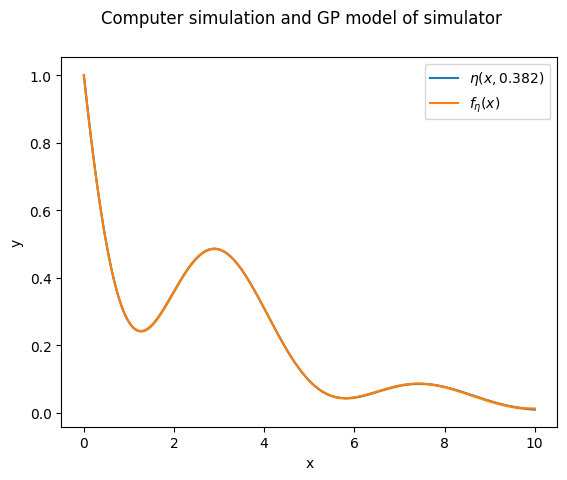

In [18]:
theta = params_transformed['theta']

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, eta(x, theta), label=fr'$\eta(x, {theta:.3f})$')
ax.plot(xpred, eta_pred_m, label=r'$f_\eta(x)$')
ax.fill_between(
    xpred, 
    eta_pred_m-1.96*eta_pred_sd, 
    eta_pred_m+1.96*eta_pred_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("Computer simulation and GP model of simulator")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Plot GP modelling true process

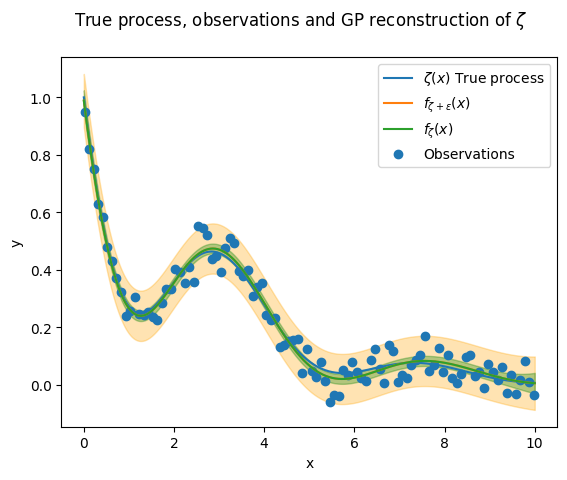

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, zeta(x), label=r'$\zeta(x)$ True process')
ax.plot(xpred, obs_pred_m, label=r'$f_{\zeta+\epsilon}(x)$')
ax.fill_between(
    xpred, 
    obs_pred_m-1.96*obs_pred_sd, 
    obs_pred_m+1.96*obs_pred_sd, 
    alpha=0.3, 
    color='orange'
)
ax.plot(xpred, zeta_pred_m, label=r'$f_{\zeta}(x)$')
ax.fill_between(
    xpred, 
    zeta_pred_m-1.96*zeta_pred_sd, 
    zeta_pred_m+1.96*zeta_pred_sd, 
    alpha=0.3, 
    color='green'
)
ax.scatter(dataloader.xf, dataloader.yf, label="Observations")

ax.legend()
fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Model discrepancy

Interpret the next figure as follows. "True discrepancy" is the actual difference between the functions used to generate the simulation output and the observations. The blue line is the function the code is trying to learn. According to the MCMC samples, $\delta(x)$ should be the blue line. $f_\delta(x)$ is the attempt to learn the blue line.

Notice the uncertainty of the GP is very large and always encompases the true discrepancy function, $0$ for all $x$.

In [20]:
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_v = zeta_pred_v + eta_pred_v
delta_gp_sd = np.sqrt(delta_gp_v)

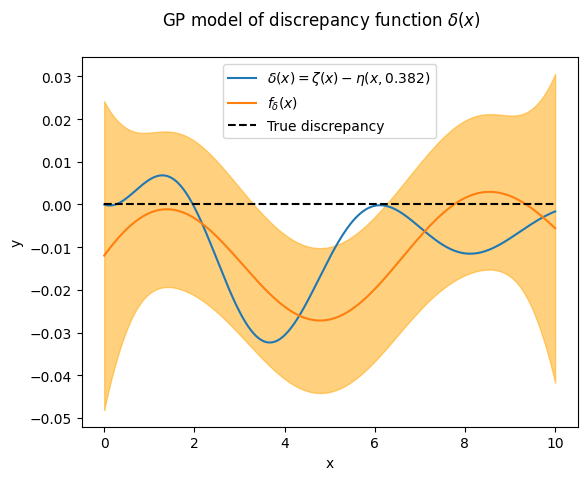

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(x, zeta(x) - eta(x, theta), label=rf'$\delta(x) = \zeta(x) - \eta(x, {theta:.3f})$')
ax.plot(xpred, delta_gp_m, label=r'$f_\delta(x)$')
ax.fill_between(
    xpred, 
    delta_gp_m-1.96*delta_gp_sd, 
    delta_gp_m+1.96*delta_gp_sd, 
    alpha=0.5, 
    color='orange'
)
ax.hlines(0, 0, 10, color='black', linestyle='--', label='True discrepancy')

ax.legend()
fig.suptitle("GP model of discrepancy function $\delta(x)$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# The Variance Problem

We assume the following:

\begin{equation}
    Var(z) = Var(\eta) + Var(\delta) + Var(\epsilon) + Var(\epsilon_\eta)
\end{equation}

In [22]:
print(np.var(dataloader.yf))
print(np.var(dataloader.yc))

0.042647153
0.117385305


In [23]:
for t in np.unique(dataloader.tc):
    a = np.var(zeta(dataloader.yc[dataloader.tc==t]))
    print(f"t={t:.3f}: {a:.4f} or 1/{1/a:.3f}")

t=0.014: 0.0696 or 1/14.362
t=0.198: 0.0392 or 1/25.505
t=0.267: 0.0366 or 1/27.337
t=0.381: 0.0355 or 1/28.190
t=0.462: 0.0347 or 1/28.823
t=0.585: 0.0340 or 1/29.414
t=0.680: 0.0339 or 1/29.497
t=0.712: 0.0339 or 1/29.475
t=0.827: 0.0341 or 1/29.288
t=0.985: 0.0346 or 1/28.941


In [24]:
obs_noise = dataloader.yf - zeta(dataloader.xf)
print(np.mean(obs_noise), np.std(obs_noise), 1/np.var(obs_noise))

-0.0010386311 0.04275985 546.9247911562288


In [25]:
a = 1/params_transformed['lambda_eta']
b = 1/params_transformed['lambda_delta']
c = 1/params_transformed['lambda_epsilon']
d = 1/params_transformed['lambda_epsilon_eta']

print('lambda_eta:', params_transformed['lambda_eta'], f'or 1/{a}')
print('lambda_delta:', params_transformed['lambda_delta'], f'or 1/{b}')
print('lambda_epsilon:', params_transformed['lambda_epsilon'], f'or 1/{c}')
print('lambda_epsilon_eta:', params_transformed['lambda_epsilon_eta'], f'or 1/{d}')

lambda_eta: 0.2960589586275322 or 1/3.377705591601728
lambda_delta: 32.67163297653954 or 1/0.030607591629046155
lambda_epsilon: 528.6065341513391 or 1/0.0018917662484166375
lambda_epsilon_eta: 203152.8234480568 or 1/4.922402667249591e-06


In [26]:
print(a+b+c+d, 1/(a+b+c+d))

3.410209871881858 0.2932370843933337


# Correlation decay

In [27]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

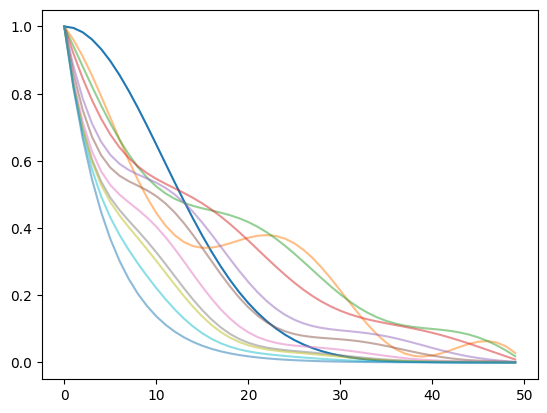

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1)

x_data = dataloader.xc[dataloader.tc_normalized==0].reshape(-1, 1)
x_corr = GP_posterior.prior.kernel.k_eta.kernels[0].gram(x_data)[0,:]
x_corr = x_corr/x_corr[0]
ax.plot(x_corr)

for t in np.unique(dataloader.tc):
    y_data = dataloader.yc[dataloader.tc==t]
    y_corr = autocorr(y_data)
    y_corr = y_corr/y_corr[0]
    ax.plot(y_corr, alpha=0.5)

plt.show()